<a href="https://colab.research.google.com/github/bmjaron/phase_4_project/blob/main/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

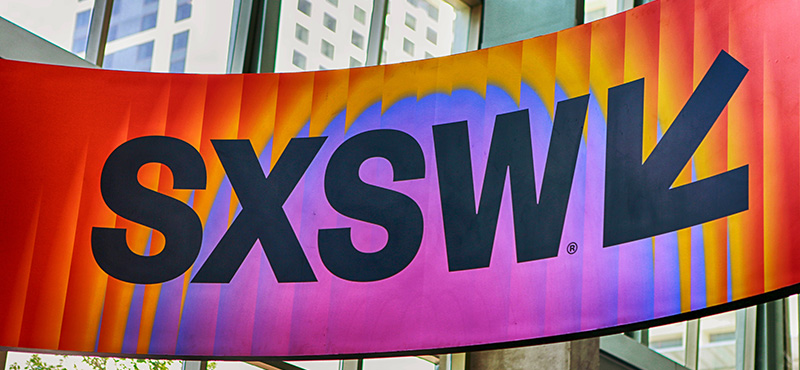

# I. Overview

Our client is SXSW and we've been tasked with building a model that helps them classify positive tweets. Our data for this project is 8,721 tweets from the conference. Many of these tweets have an emotion associated with them.

Tweets differ greatly from traditional text documents, as they are often in short-hand and have specific Twitter words that don't provide much meaning to the overall tweet. Additionally, there are usernames and online abbreviation containing special symbols and numbers. In order to account for this we made heavy use of regular expresions to remove this and leave as many pure words as possible. We also tokenized, stemmed and lemmatized, in addition to removing Twitter and SXSW specific words.

A characteristic of our data was that it was imbalanced. Positive tweets (our target) accounted for only about 30% of the data. As such, we created 2 classes, positive and non-positive tweets, and randomly undersample the majority class in order to train on a balanced dataset.

Our final model was a multinomial naive Bayes' model. Our metric that we scored this model on was recall, as we found it imperative to correctly identify as many positive tweets as possible. This would provide the SXSW with the ability to build off that positive sentiment. Our model had a 73% recall score, which means that we can identify 73% of all positive tweets.

# II. Business Understanding

South by Southwest (abb. SXSW) is a unique event in Austin, TX that contains festivals for film and music, as well as conferences to showcase leading players and products in the tech industry. We have been tasked with sifting through numerous tweets about the SXSW tech conference in order to provide insight. Our goal in this project will be to build a model capable of predicting positive tweets, which should in turn provide SXSW the framework to identify and fortify its strengths.

# III. Data Understanding

## A. Data Collection and Description

We'll begin by importing necessary libraries.

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import sklearn
import nltk
from nltk.collocations import *
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

We'll now load the data and preview.

In [48]:
df = pd.read_csv('https://raw.githubusercontent.com/bmjaron/phase_4_project/main/data.csv')

df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [49]:
df.shape

(8721, 3)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8720 non-null   object
 1   emotion_in_tweet_is_directed_at                     3169 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


In order to make the columns easier to work with, we're going to change the column names.

In [51]:
df = df.rename(columns={'tweet_text': 'text', 'emotion_in_tweet_is_directed_at': 'directed_at', 'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'})

We'll look at the different emotions shown in tweets.

In [52]:
df['emotion'].value_counts()

No emotion toward brand or product    5156
Positive emotion                      2869
Negative emotion                       545
I can't tell                           151
Name: emotion, dtype: int64

We can tell that we have data for 8,721 tweets that contain the text of the tweet, the brand or product that each given tweet is directed at, and whether or not the emotion expressed by the tweet is either positive or negative. We also see that we have some instances of null values.

What will be most significant for us, though, is that we have an imbalanced dataset. Our job is to predict positive tweets, but those positive tweets only account for a third of the datset. This will have to be accounted for later.

## B. Exploratory Data Analysis

### **Are tweets generally positive or negative?**

We saw earlier that the emotions of our tweets can be broken down into 4 categories: 1) no emotion, 2) positive, 3) negative, 4) unable to determine emotion. Below, we'll visualize the break down.

Text(0.5, 1.0, 'Emotion Breakdown')

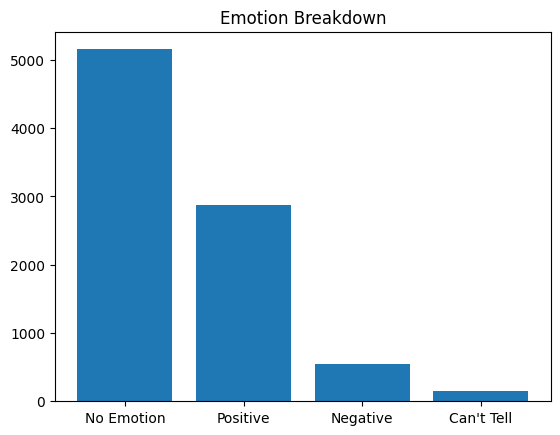

In [53]:
plt.bar(x=['No Emotion', 'Positive', 'Negative', "Can't Tell"],
        height=[df['emotion'].value_counts()[n] for n in range(4)])
plt.title('Emotion Breakdown')


### **What is the emotion of tweet based on products/brands?**




Another interesting thing to consider is how the emotion changes based on product and company.

In [54]:
#Check who tweets are directed at
df['directed_at'].value_counts()

iPad                               910
Apple                              640
iPad or iPhone App                 451
Google                             412
iPhone                             288
Other Google product or service    282
Android App                         78
Android                             74
Other Apple product or service      34
Name: directed_at, dtype: int64

We'll begin by looking at sentiment based on company.

In [55]:
#Lump products of company together in bins
map_dict = {'Apple': ['iPad', 'Apple', 'iPad or iPhone App', 'iPhone', 'Other Apple product or service'],
            'Google': ['Google', 'Other Google product or service'],
            'Android': ['Android App', 'Android']}

#Create a dataframe to contain our new results
companies = df.copy()
companies = companies.dropna(axis=0)

#Map dictionary on dataframe
companies['directed_at'] = companies['directed_at'].map(lambda x: 'Apple' if x in map_dict['Apple'] else (
                                                        'Google' if x in map_dict['Google'] else
                                                        'Android'))

companies['directed_at'].value_counts()

Apple      2323
Google      694
Android     152
Name: directed_at, dtype: int64

# IV. Data Preparation

We're going to prepare our tweets for modeling. To being, we'll preview some of the text of the tweets to see what we have in front of us.

In [56]:
#Preview text of tweets

for tweet in df['text'][:10]:
  print(tweet)

.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.
@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW
@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.
@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw
@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)
@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd
nan
#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan
Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB
Counting down the days 

We're going to create a function that cleans tweets, and then map this on the data frame. Many of the regular expressions used come from the [following](https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model) Kaggle notebook.

In [57]:
import string

def clean_tweets(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df.dropna(subset=['text'], inplace=True)
df['text'] = df['text'].map(lambda x: clean_tweets(x))

Let's preview some cleaned tweets.

In [58]:
for tweet in df['text'][10:20]:
  print(tweet)

find amp start impromptu parties at sxsw with hurricaneparty  i cant wait til the android app comes out
foursquare ups the game just in time for sxsw   still prefer gowalla by far best looking android app to date
gotta love this sxsw google calendar featuring top parties show cases to check out  rt hamsandwich via ischafer gt
great sxsw ipad app from madebymany 
haha awesomely rad ipad app by madebymany  hollergram sxsw
holler gram for ipad on the itunes app store    via marcisken sxsw
i just noticed dst is coming this weekend how many iphone users will be an hour late at sxsw come sunday morning sxsw iphone
just added my sxsw flights to planely matching people on planesairports also downloaded the klm iphone app nicely done
must have sxsw app rt malbonster lovely review from forbes for our sxsw ipad app holler gram  
need to buy an  while im in austin at sxsw not sure if ill need to q up at an austin apple store


These look great! We're going to move on to tokenization. We'll use NLTK's built in function to accomplish this.

In [59]:
#Map function on tweets
df['text'] = df['text'].map(lambda x: nltk.word_tokenize(x))

In [60]:
#Preview
df.head()

,text,directed_at,emotion
0,"[i, have, a, iphone, after, hrs, tweeting, at,...",iPhone,Negative emotion
1,"[jessedee, know, about, fludapp, awesome, ipad...",iPad or iPhone App,Positive emotion
2,"[swonderlin, can, not, wait, for, ipad, also, ...",iPad,Positive emotion
3,"[sxsw, i, hope, this, years, festival, isnt, a...",iPad or iPhone App,Negative emotion
4,"[sxtxstate, great, stuff, on, fri, sxsw, maris...",Google,Positive emotion


Our next stop is to remove stopwords. One of the most common methods is to use NLTK's corpus of English stopwords. We map thru the dataset and only include words not found in this list.

In [61]:
from nltk.corpus import stopwords

#Store English stopwords as object
stop_words = stopwords.words('english')

#Map thru and remove
df['text'] = df['text'].map(lambda x: [word for word in x if word not in stop_words])

df.head()


,text,directed_at,emotion
0,"[iphone, hrs, tweeting, riseaustin, dead, need...",iPhone,Negative emotion
1,"[jessedee, know, fludapp, awesome, ipadiphone,...",iPad or iPhone App,Positive emotion
2,"[swonderlin, wait, ipad, also, sale, sxsw]",iPad,Positive emotion
3,"[sxsw, hope, years, festival, isnt, crashy, ye...",iPad or iPhone App,Negative emotion
4,"[sxtxstate, great, stuff, fri, sxsw, marissa, ...",Google,Positive emotion


For our next step, we're going to stem and lemmatize using popular NLTK code.

In [62]:
#Porter Stemmer
ps = nltk.PorterStemmer()

df['text'] = df['text'].map(lambda x: [ps.stem(word) for word in x])

In [63]:
#Lemmatizer
lm = nltk.WordNetLemmatizer()

df['text'] = df['text'].map(lambda x: [lm.lemmatize(word) for word in x])

Now that we've completed the cleaning and tokenization, it's time to look at the frequency distribution of words. We'll, again, accomplish this using NLTK's built-in functions.

In [64]:
from nltk.probability import FreqDist

#Create FreqDist from list of words from all tokenized tweets

stopped_words = [word for tweet in df['text'] for word in tweet]

fdist = FreqDist(stopped_words)

First, we'll look at the 20 most common words.

In [65]:
fdist.most_common(20)

[('sxsw', 9002),
 ('mention', 6723),
 ('link', 4047),
 ('rt', 2917),
 ('ipad', 2424),
 ('googl', 2404),
 ('appl', 2119),
 ('iphon', 1470),
 ('store', 1435),
 ('new', 1064),
 ('app', 987),
 ('austin', 923),
 ('launch', 806),
 ('amp', 695),
 ('social', 620),
 ('circl', 616),
 ('today', 563),
 ('popup', 561),
 ('android', 540),
 ('get', 515)]

It comes as no surprise that the most common words is SXSW, which is what every tweet in the database concerns. Additionally, there are tons of instances of Twitter specific words.

Before we address this, we'll look at some bigrams.

In [66]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

finder = BigramCollocationFinder.from_words(stopped_words)

scored = finder.score_ngrams(bigram_measures.raw_freq)


In [67]:
scored[:20]

[(('rt', 'mention'), 0.027218934911242602),
 (('sxsw', 'link'), 0.008822821956030211),
 (('link', 'sxsw'), 0.007129455909943715),
 (('sxsw', 'rt'), 0.00653292923461779),
 (('mention', 'mention'), 0.005628517823639775),
 (('mention', 'sxsw'), 0.005532303843748497),
 (('appl', 'store'), 0.005484196853802858),
 (('link', 'rt'), 0.004878048780487805),
 (('sxsw', 'mention'), 0.0046278924327704815),
 (('social', 'network'), 0.004339250493096647),
 (('mention', 'googl'), 0.004166065329292346),
 (('new', 'social'), 0.003925530379564151),
 (('googl', 'launch'), 0.003377110694183865),
 (('mention', 'rt'), 0.0032327897243469477),
 (('network', 'call'), 0.0031365757444556694),
 (('store', 'sxsw'), 0.0031269543464665416),
 (('via', 'mention'), 0.0030596045605426466),
 (('sxsw', 'appl'), 0.0030307403665752633),
 (('call', 'circl'), 0.00300187617260788),
 (('iphon', 'app'), 0.00300187617260788)]

As we mentioned are some unique words that need to be removed, including 'rt', 'mention' and 'link'. These are so common that it's hard to imagine that they'll add any value to our model.

In [68]:
twitter_words = ['rt', 'mention', 'link', 'sxsw']

#Remove words
df['text'] = df['text'].map(lambda x: [word for word in x if word not in twitter_words])

#Updated list of words
stopped_words_new = [word for tweet in df['text'] for word in tweet]

#Update freq dist
fdist = FreqDist(stopped_words_new)

#Most common words
_20 = fdist.most_common(20)

#Show most common words and count
_20

[('ipad', 2424),
 ('googl', 2404),
 ('appl', 2119),
 ('iphon', 1470),
 ('store', 1435),
 ('new', 1064),
 ('app', 987),
 ('austin', 923),
 ('launch', 806),
 ('amp', 695),
 ('social', 620),
 ('circl', 616),
 ('today', 563),
 ('popup', 561),
 ('android', 540),
 ('get', 515),
 ('open', 495),
 ('network', 471),
 ('line', 440),
 ('go', 416)]

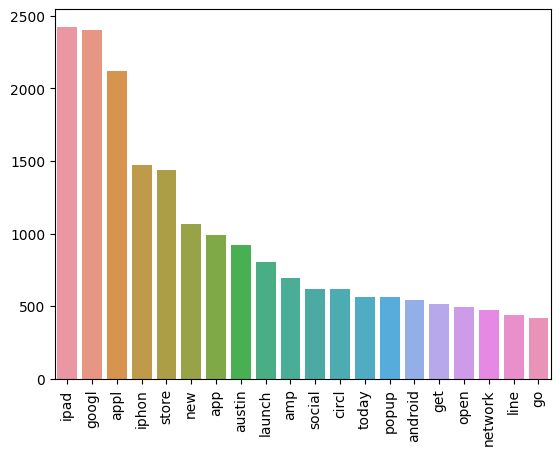

In [69]:
def freq_dist_plot(fdist):
  words = [tup[0] for tup in fdist]
  counts = [tup[1] for tup in fdist]
  sns.barplot(x=words, y=counts)
  plt.xticks(rotation=90)

freq_dist_plot(_20)

The most common words in tweets about a tech festival are not in the least bit surprising.

Let's try to see if there's a difference depending on positive or non-positive tweets.

[Text(0.5, 1.0, 'Non-Positive Tweets')]

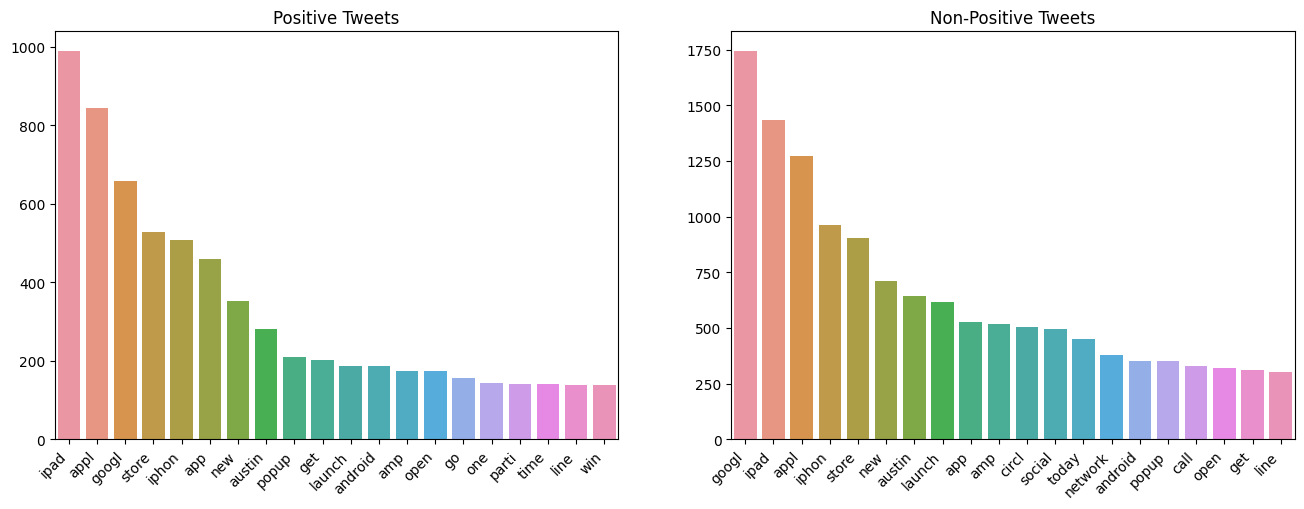

In [70]:
pos = df[df['emotion'] == 'Positive emotion']
non_pos = df[df['emotion'] != 'Positive emotion']

#Make list of words
pos_words = [word for tweet in pos['text'] for word in tweet]
non_pos_words = [word for tweet in non_pos['text'] for word in tweet]

#Freq dist
pos_fdist = FreqDist(pos_words)
non_pos_fdist = FreqDist(non_pos_words)

#Most common
pos_20 = pos_fdist.most_common(20)
non_pos_20 = non_pos_fdist.most_common(20)

#Plot side by side

fig, axes = plt.subplots(1,2, figsize=(16, 6))
fig.autofmt_xdate(rotation=45)

sns.barplot(x=[tup[0] for tup in pos_20],
            y=[tup[1] for tup in pos_20],
            ax=axes[0]).set(title='Positive Tweets')

sns.barplot(x=[tup[0] for tup in non_pos_20],
            y=[tup[1] for tup in non_pos_20],
            ax=axes[1]).set(title='Non-Positive Tweets')



Here too, we can't seem to discern any significant or meaningful differences. Before we move on, let's check some n-grams of positive and non-positive tweets.

In [71]:
#Positive n-grams
bigram_measures = nltk.collocations.BigramAssocMeasures()

finder = BigramCollocationFinder.from_words(pos_words)

scored = finder.score_ngrams(bigram_measures.raw_freq)

scored[:20]

[(('appl', 'store'), 0.007863648001170403),
 (('iphon', 'app'), 0.005486266047328188),
 (('popup', 'store'), 0.004315862623898175),
 (('appl', 'open'), 0.003913536447094108),
 (('social', 'network'), 0.0031454592004681614),
 (('ipad', 'app'), 0.002852858344610658),
 (('googl', 'map'), 0.00281628323762847),
 (('new', 'social'), 0.002779708130646282),
 (('appl', 'popup'), 0.0026334077027175304),
 (('downtown', 'austin'), 0.0025236823817709666),
 (('store', 'downtown'), 0.0024871072747887787),
 (('googl', 'launch'), 0.002413957060824403),
 (('temporari', 'store'), 0.002413957060824403),
 (('open', 'popup'), 0.002340806846860027),
 (('new', 'ipad'), 0.002304231739877839),
 (('marissa', 'mayer'), 0.0021945064189312752),
 (('network', 'call'), 0.0020847810979847115),
 (('call', 'circl'), 0.0020116308840203356),
 (('launch', 'major'), 0.0019750557770381477),
 (('major', 'new'), 0.0019750557770381477)]

In [72]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

finder = BigramCollocationFinder.from_words(non_pos_words)

scored = finder.score_ngrams(bigram_measures.raw_freq)

scored[:20]

[(('social', 'network'), 0.0067711715054262125),
 (('appl', 'store'), 0.006622762266951117),
 (('new', 'social'), 0.006158983396716446),
 (('googl', 'launch'), 0.005287079120675262),
 (('network', 'call'), 0.004990260643725072),
 (('call', 'circl'), 0.004767646786012429),
 (('major', 'new'), 0.004415174844634079),
 (('launch', 'major'), 0.004266765606158984),
 (('possibl', 'today'), 0.0036545774974492164),
 (('appl', 'open'), 0.0036360263426398294),
 (('circl', 'possibl'), 0.0036360263426398294),
 (('popup', 'store'), 0.0034319636397365737),
 (('iphon', 'app'), 0.003060940543548836),
 (('googl', 'circl'), 0.0030052870791206754),
 (('store', 'austin'), 0.002541508208886003),
 (('temporari', 'store'), 0.002281792041554587),
 (('downtown', 'austin'), 0.002096280493460718),
 (('appl', 'popup'), 0.002077729338651331),
 (('marissa', 'mayer'), 0.0020591781838419443),
 (('store', 'downtown'), 0.001910768945366849)]

To no surprise, there is still no significant difference.

In a last attempt to glean some meaning from our formatted and tokenized tweets, we're going to make lists of uniquely positive and non-positive words.

In [73]:
#Isolate positive and non-positive tweets
positive_tweets = df[df['emotion'] == 'Positive emotion']
non_positive_tweets = df[df['emotion'] != 'Positive emotion']

#Create lists of positive and non-positive words
positive_words = [word for tweet in positive_tweets['text'] for word in tweet]
non_positive_words = [word for tweet in non_positive_tweets['text'] for word in tweet]

In [74]:
unique_positives = []
for word in positive_words:
  if word not in non_positive_words:
    unique_positives.append(word)

unique_non_positives = []
for word in non_positive_words:
  if word not in positive_words:
    unique_non_positives.append(word)

Now, we'll plot the the most common unique positive and non-positive words.

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 1770 (\N{ARABIC EMPTY CENTRE LOW STOP}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Matplotlib currently does not support Arabic natively.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1770 (\N{ARABIC EMPTY CENTRE LOW STOP}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Arabic natively.
  fig.canvas.print_figure(bytes_io, **kw)


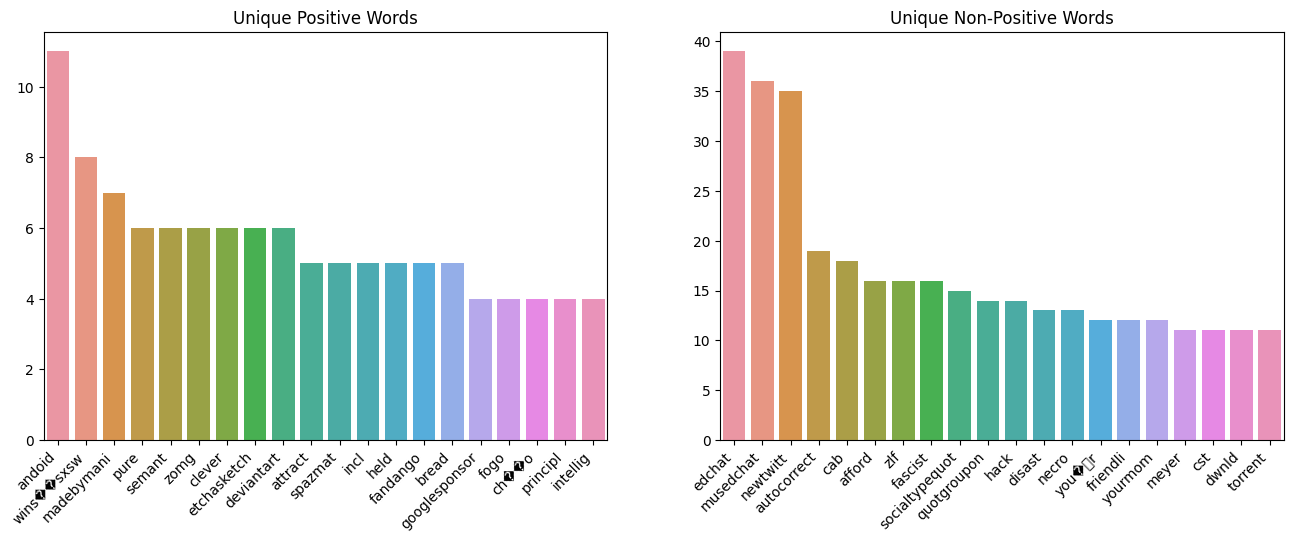

In [75]:
#Build histograms
fdist_positives = FreqDist(unique_positives).most_common(20)
fdist_non_positives = FreqDist(unique_non_positives).most_common(20)

fig, axes = plt.subplots(1,2, figsize=(16, 6));
fig.autofmt_xdate(rotation=45)

sns.barplot(x=[tup[0] for tup in fdist_positives],
            y=[tup[1] for tup in fdist_positives],
            ax=axes[0]).set(title='Unique Positive Words');

sns.barplot(x=[tup[0] for tup in fdist_non_positives],
            y=[tup[1] for tup in fdist_non_positives],
            ax=axes[1]).set(title='Unique Non-Positive Words');

Something that stands out is the rarity of finding unique positive or non-positive words. Also, some of these words are a bit unintelligible, making difficult to glean insights.

# V. Modeling

## A. Splitting data into positive and non-positive, and performing train/test split with undersampling

Let's recall the total number of tweets and the breakdown of tweets by sentiment.

In [76]:
#Show total number of tweets
print(f"There are {len(df)} tweets in the data set")

There are 8720 tweets in the data set


In [77]:
df['emotion'].value_counts()

No emotion toward brand or product    5155
Positive emotion                      2869
Negative emotion                       545
I can't tell                           151
Name: emotion, dtype: int64

Our goal it to be able to predict positive tweets. As such we will split the data into two classes, positive and non-positive. '0' will be non-positive and '1' will be positive.


In [78]:
#Make an unchanged copy for future use
df_copy = df.copy()

df['emotion'] = df['emotion'].map(lambda x: 1 if x == 'Positive emotion' else 0)

df['emotion'].value_counts()

0    5851
1    2869
Name: emotion, dtype: int64

Next, we'll split our data into training and testing sets.

In [79]:
y = df['emotion']

X = df.drop(['directed_at', 'emotion'], 1)

<ipython-input-79-f8c9963a5efc>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df.drop(['directed_at', 'emotion'], 1)


We're going to run 2 train/test splits in order to leave an untouched holdout set for the final model evaluation.

In [80]:
#Perform train-test split

from sklearn.model_selection import train_test_split

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In order to properly train our model we're going to undersample the majority class of non-positive tweets.

In [81]:
from imblearn.under_sampling import RandomUnderSampler

#This will give us a perfectly even sample
rus = RandomUnderSampler(sampling_strategy=1, random_state=0)

#Resample the data
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

#Preview class breakdown
y_train_under.value_counts()

0    1825
1    1825
Name: emotion, dtype: int64

## B. Using count vectorizer to transform training and testing data and prepare for baseline model

In [82]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

To begin, we're going to use count vectorizer to transform our training and testing data in order to prepare it for classification models.

In [83]:
#Change lists of tokens to straight sentences in order to vectorized
X_train_under_vectorized = X_train_under['text'].map(lambda x: ' '.join(word for word in x))
X_test_vectorized = X_test['text'].map(lambda x: ' '.join(word for word in x))

#Instantiate count vectorizer
cv = CountVectorizer()

#Fit and transform training data and transform testing data
vec_train = cv.fit_transform(X_train_under_vectorized)
vec_test = cv.transform(X_test_vectorized)

#Building vectorized dataframe for training data
X_train_under_vectorized = pd.DataFrame(data = vec_train.toarray(),
                                        columns = cv.get_feature_names_out())

#Building vectorized dataframe for testing data
X_test_vectorized = pd.DataFrame(data = vec_test.toarray(),
                                 columns = cv.get_feature_names_out())


#Set indexes
X_train_under_vectorized.index = X_train_under['text']
X_test_vectorized.index = X_test['text']

#Preview training data
X_train_under_vectorized.head()

,aapl,aaron,aarpbulletin,abba,abil,abl,abnorm,absolut,absolutley,abt,...,zip,zite,zlf,zm,zomb,zombi,zomg,zoom,zynga,ξс
text,,,,,,,,,,,,,,,,,,,,,
"[abl, afford, attend, buy, ipad, today, consid, save, japan, earthquak, relief]",0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"[vai, come̤ar, palestra, exchief, evangelist, appl]",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"[major, appl, io, updat, day, geniu, project, manag, came, brilliant, idea, nowhammi]",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"[cant, wait, give, ipad, someon, want, head, enter, must, present, win]",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"[get, look, rumor, appl, quotpopupquot, store, austin]",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
#Preview testing data
X_test_vectorized.head()

,aapl,aaron,aarpbulletin,abba,abil,abl,abnorm,absolut,absolutley,abt,...,zip,zite,zlf,zm,zomb,zombi,zomg,zoom,zynga,ξс
text,,,,,,,,,,,,,,,,,,,,,
"[googl, parti, line, start, behind, ha, germ, put, towel, earli]",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"[quotvia, guy, kawasaki, talk, enchant, know, stuff, book, internet, appl, quot]",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"[wander, googl, doodl, present, see, present, fun]",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"[iphon, batteri, made]",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"[appl, set, open, popup, shop, core, action, via]",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


These look great! We're ready to run our initial iterations of models.

## C. Baseline model: vanilla logistic regression

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, confusion_matrix

In [89]:
lr = LogisticRegression()

lr.fit(X_train_under_vectorized, y_train_under)

lr_train_pred = lr.predict(X_train_under_vectorized)
lr_test_pred = lr.predict(X_test_vectorized)

In [90]:
print(f"The recall score for our training data is: {recall_score(y_train_under, lr_train_pred)}")
print(f"The recall score for our testing data is: {recall_score(y_test, lr_test_pred)}")

The recall score for our training data is: 0.9002739726027398
The recall score for our testing data is: 0.6585365853658537


## D. Second iteration: Multinomial Bayes' with count vectorizer

Let's try a naive Bayes' model on the training set.

In [91]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()

mnb.fit(X_train_under_vectorized, y_train_under)

y_train_pred = mnb.predict(X_train_under_vectorized)
y_test_pred = mnb.predict(X_test_vectorized)

Now that we've fit the models and used them to predict both the training and testing data, we can check our model performance.

In [92]:
recall_train = recall_score(y_train_under, y_train_pred)
recall_test = recall_score(y_test, y_test_pred)

print(f"The recall score for our training data is: {recall_train}")
print(f"The recall score for our testing data is: {recall_test}")

The recall score for our training data is: 0.8926027397260274
The recall score for our testing data is: 0.7250554323725056


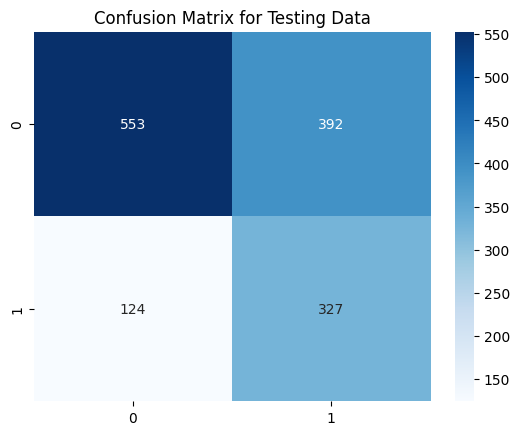

In [93]:
#Confusion matrix for testing data
cm = confusion_matrix(y_test, y_test_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g').set_title("Confusion Matrix for Testing Data");

Not bad! Our model score an 89% recall score on the training data, and on the testing data we're able to predict true positives with about a 73% recall score. This is an improvement over the baseline model. We'll see if we can improve this using TD-IDF vectorization instead.

## E. Third iteration: MNB with TF-IDF vectorizer

In an attempt to better the model, we'll replace using a count vectorizer with using the TF-IDF vectorizer. TF-IDF stands for term frequency-inverse document frequency and is a way to measure the relevance of a word to a given document in a set of documents. It penalizes words that appear frequently throughout all documents. As such, this may help us eliminate some words that don't add value to our model.

In [94]:
#Instantiate the vectorizer
tf_idf = TfidfVectorizer()

#Prepare text for transforming
X_train_under_tf = X_train_under['text'].map(lambda x: ' '.join(word for word in x))
X_test_tf = X_test['text'].map(lambda x: ' '.join(word for word in x))

#Fit and transform training data and transform testing data
tf_train = tf_idf.fit_transform(X_train_under_tf)
tf_test = tf_idf.transform(X_test_tf)

#Building vectorized dataframe for training data
X_train_under_tf = pd.DataFrame(data = tf_train.toarray(),
                                columns = tf_idf.get_feature_names_out())

#Building vectorized dataframe for testing data
X_test_tf = pd.DataFrame(data = tf_test.toarray(),
                         columns = tf_idf.get_feature_names_out())


#Set indexes
X_train_under_tf.index = X_train_under['text']
X_test_tf.index = X_test['text']

#Preview training data
X_train_under_tf.head()

,aapl,aaron,aarpbulletin,abba,abil,abl,abnorm,absolut,absolutley,abt,...,zip,zite,zlf,zm,zomb,zombi,zomg,zoom,zynga,ξс
text,,,,,,,,,,,,,,,,,,,,,
"[abl, afford, attend, buy, ipad, today, consid, save, japan, earthquak, relief]",0.0,0.0,0.0,0.0,0.0,0.335865,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"[vai, come̤ar, palestra, exchief, evangelist, appl]",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"[major, appl, io, updat, day, geniu, project, manag, came, brilliant, idea, nowhammi]",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"[cant, wait, give, ipad, someon, want, head, enter, must, present, win]",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"[get, look, rumor, appl, quotpopupquot, store, austin]",0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
X_test_tf.head()

,aapl,aaron,aarpbulletin,abba,abil,abl,abnorm,absolut,absolutley,abt,...,zip,zite,zlf,zm,zomb,zombi,zomg,zoom,zynga,ξс
text,,,,,,,,,,,,,,,,,,,,,
"[googl, parti, line, start, behind, ha, germ, put, towel, earli]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"[quotvia, guy, kawasaki, talk, enchant, know, stuff, book, internet, appl, quot]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"[wander, googl, doodl, present, see, present, fun]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"[iphon, batteri, made]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"[appl, set, open, popup, shop, core, action, via]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


With the dataframes in check, we'll run the model.

In [96]:
#Instantiate
mnb_tfidf = MultinomialNB()

#Fit to training data
mnb_tfidf.fit(X_train_under_tf, y_train_under)

#Predict training and testing
y_train_pred_2 = mnb_tfidf.predict(X_train_under_tf)
y_test_pred_2 = mnb_tfidf.predict(X_test_tf)

In [97]:
#Print recall scores
print(f"The recall score for the training data is {recall_score(y_train_under, y_train_pred_2)}")
print(f"The recall score for the testing data is {recall_score(y_test, y_test_pred_2)}")

The recall score for the training data is 0.896986301369863
The recall score for the testing data is 0.720620842572062


We see that the scores are more or less the same. There have been no particular improvements using the different vectorizer.

## F. Fourth iteration: Random forest

In a last attempt to improve the score, we'll turn to the random forest ensemble.

In [98]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100)

rfc.fit(X_train_under_tf, y_train_under)

rfc_pred_train = rfc.predict(X_train_under_tf)
rfc_pred_test = rfc.predict(X_test_tf)

In [99]:
print(f"The recall score for the training data is {recall_score(y_train_under, rfc_pred_train)}")
print(f"The recall score for the testing data is {recall_score(y_test, rfc_pred_test)}")

The recall score for the training data is 0.9775342465753425
The recall score for the testing data is 0.7095343680709535


# VI. Final Model Evaluation

By a slim margin, our MNB model with the count vectorizer seems the most promising. As such, we'll run it on the holdout data.

In [101]:
#Change lists of tokens to straight sentences in order to vectorized
X_holdout_vectorized = X_holdout['text'].map(lambda x: ' '.join(word for word in x))

#Transform holdout set
vec_holdout = cv.transform(X_holdout_vectorized)

#Build dataframe
X_holdout_vectorized = pd.DataFrame(data = vec_holdout.toarray(),
                                    columns = cv.get_feature_names_out())


#Set indexes
X_holdout_vectorized.index = X_holdout['text']

In [103]:
#Predict
y_holdout_pred = mnb.predict(X_holdout_vectorized)

print(f"The recall score for our testing data is: {recall_score(y_holdout, y_holdout_pred)}")

The recall score for our testing data is: 0.7352445193929174


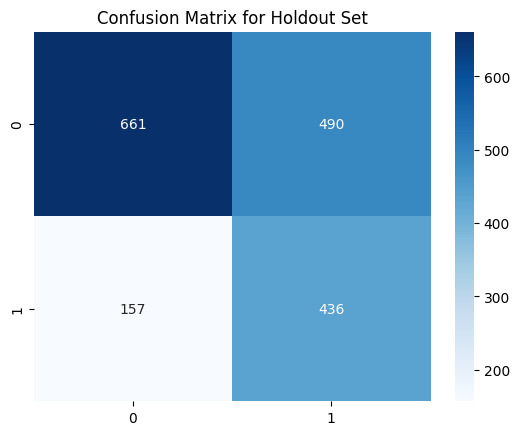

In [104]:
#Confusion matrix for holdout data
cm = confusion_matrix(y_holdout, y_holdout_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g').set_title("Confusion Matrix for Holdout Set");

For our final model, we've selected a multinomial Bayes' classifier. This model had a 73% recall score, which means that of all of the instances of positive tweets, we can pick up on 73% of them. This will prove useful for isolating positive sentiment, and using that sentiment to bolster the existing strengths of SXSW.